In [66]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Load the dataset

In [88]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [89]:
print(x_train.shape)
print(y_train.shape)
 
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [90]:
X = np.concatenate((x_train, x_test))
X.shape

(70000, 28, 28)

In [91]:
y = np.concatenate([y_train, y_test])
y.shape

(70000,)

### Dividing dataset into a training set (80%), an evaluation set (10%) and a test set (10%)

In [92]:
train_ratio = 0.9
test_ratio = 0.1

# train is now 80% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio)

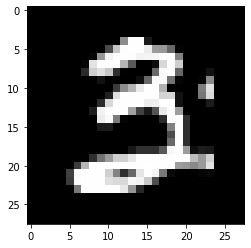

In [93]:
plt.imshow(x_train[0], cmap='gray')

In [94]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


# images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [95]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [112]:
# simple early stopping
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

In [116]:
 model = keras.Sequential([
     layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
     layers.MaxPooling2D (2,2),   
    
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(.25),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [117]:
# fit model
history = model.fit(x_train, y_train,  validation_split = 0.11, batch_size = 128, epochs=4, callbacks=[es])

Epoch 1/4
439/439 [==============================] - 20s 46ms/step - loss: 0.2285 - accuracy: 0.9335 - val_loss: 0.0837 - val_accuracy: 0.9729
Epoch 2/4
439/439 [==============================] - 20s 45ms/step - loss: 0.0704 - accuracy: 0.9794 - val_loss: 0.0629 - val_accuracy: 0.9808
Epoch 3/4
439/439 [==============================] - 20s 46ms/step - loss: 0.0484 - accuracy: 0.9849 - val_loss: 0.0501 - val_accuracy: 0.9844
Epoch 4/4
439/439 [==============================] - 20s 45ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0429 - val_accuracy: 0.9857


In [118]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04400882124900818
Test accuracy: 0.9864285588264465


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


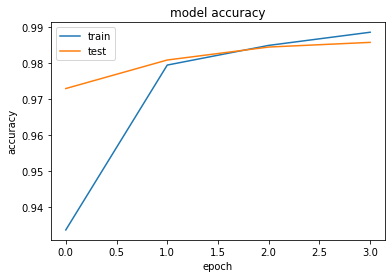

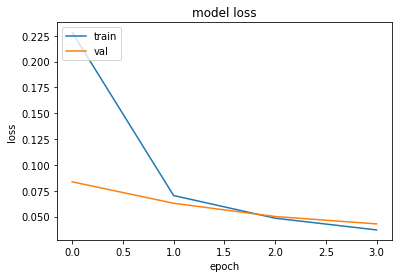

In [119]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()